[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlpacaDB/jquants-api-sample/blob/main/20220928_jquantsapi_tutorial.ipynb)

# J-Quants APIを用いた株式分析チュートリアル用データ取得

本ノートブックは、2部構成になっています。
前半で日本取引所グループが提供している [株式分析チュートリアル](https://japanexchangegroup.github.io/J-Quants-Tutorial/) の実行に必要となる株価・財務情報データを [J-Quants API](https://jpx-jquants.com/#jquants-api) を使用して取得し、データを調整し、保存するところまでを行います。
後半では、取得したデータを用いて[J-Quants株式分析チュートリアル第2章のハンズオンノートブック](https://github.com/JapanExchangeGroup/J-Quants-Tutorial/blob/main/handson/Chapter02/20210121-chapter02-tutorial.ipynb) の再現を行います。

Google Colab上で動作確認を行っています。

---

**このノートブックはGoogle Driveを使用します。**

- Google Drive の以下のフォルダーにデータを書き込みます。
    - `MyDrive/drive_ws/marketdata`

## J-Quants API 利用準備: リフレッシュトークンの取得
J-Quants APIを利用するためには [J-Quants API のメニューページ](https://application.jpx-jquants.com/) から取得できるリフレッシュトークンが必要になります。
会員登録とリフレッシュトークンの取得を完了させてから次に進みます。

## ライブラリとデータ保存先の設定

必要なライブラリのinstall/importと設定を行います。

本ノートブックでは、J-Quants API のPythonクライアントライブラリである [jquants-api-client-python](https://github.com/J-Quants/jquants-api-client-python) を使用します。

In [2]:
# jquants-api-client をインストールします
!pip install jquants-api-client==0.1.4

import getpass
import os
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
from requests import HTTPError

import jquantsapi


# --- コンフィグ ---
# Googleドライブをマウントするディレクトリ
GOOGLE_DRIVE_MOUNT_DIR_PATH = "/content/drive"

# データを保存するGoogleドライブ上のディレクトリ
STORAGE_DIR_PATH = f"{GOOGLE_DRIVE_MOUNT_DIR_PATH}/MyDrive/drive_ws/marketdata"

# 各種CSVデータを保存するファイルパス
# 元データ
raw_stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_list.csv.gz"
raw_stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_fin.csv.gz"
raw_stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_price.csv.gz"
# 処理済みデータ
stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/stock_list.csv.gz"
stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/stock_fin.csv.gz"
stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/stock_price.csv.gz"
stock_labels_csvfile_path = f"{STORAGE_DIR_PATH}/stock_labels.csv.gz"

# J-Quants API から取得するデータの期間
start_dt: datetime = datetime(2019, 1, 1)
# デバッグ中は短い期間を使う
#start_dt: datetime = datetime(2022, 3, 1)

end_dt: datetime = datetime(2022, 8, 31)

# 目的変数(ラベル)の作成時に、何営業日後の価格レンジを予測するか。
# たとえばlookaheads = [5, 10, 20] であった場合、5営業日後、10営業日後, 20営業日後
# の高値・安値を取得し、stock_labels変数には下記のカラムが付与されたdataframeが保存されます。
# "label_date_5", "label_high_5", "label_low_5", 
# "label_date_10", "label_high_10", "label_low_10",
# "label_date_20", "label_high_20", "label_low_20",
#lookaheads = [5, 10, 20]
lookaheads = [20] # 数が多いと目的変数作成に時間がかかるので一旦20だけにする

# 予測対象の銘柄一覧。多いと時間がかかるのでデバッグ中は下記の銘柄に絞る。
# 下記が空配列だった場合は全銘柄が対象になります。
example_codes = [7203, 9201, 6758] # toyota, jal, sony (特に銘柄選定に意味はないです)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Googleドライブをマウント
from google.colab import drive
drive.mount(GOOGLE_DRIVE_MOUNT_DIR_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# データ保存先のフォルダーを作成しておきます
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)

## リフレッシュトークンの設定

入力ボックスに https://application.jpx-jquants.com/ から取得したJ-Quants APIのリフレッシュトークンを入力してください。

In [5]:
refresh_token = getpass.getpass(prompt="J-Quants Refresh Token:")
# リフレッシュトークンを使用できるか検証します。
test_cli = jquantsapi.Client(refresh_token=refresh_token)
try:
    id_token = test_cli.get_id_token()
    if len(id_token) > 0:
        print("refresh_tokenは正常です。次の手順に進んでください。")
except HTTPError:
    print("refresh_tokenを使用できません。再度値を確認してください。")

J-Quants Refresh Token:··········
refresh_tokenは正常です。次の手順に進んでください。


## データのダウンロードおよび保存

銘柄一覧および、上記で設定したデータ取得期間(start_dt から end_dt) の
全銘柄の価格と財務情報データを取得します。加えて、取得したデータを保存しておきます。データ処理方法を変えたりしても再度データ取得しなくて良くなります。

このステップの実行にはデータを取得する期間によって数十分ほど時間がかかります。

In [ ]:
cli = jquantsapi.Client(refresh_token=refresh_token)

# 銘柄一覧
if os.path.isfile(raw_stock_list_csvfile_path):
    print(f"すでに{raw_stock_list_csvfile_path}が存在するのでデータ取得をスキップします。")
else:
    stock_list_load: pd.DataFrame = cli.get_list()
    stock_list_load.to_csv(raw_stock_list_csvfile_path, compression="gzip", index=False)
stock_list_load: pd.DataFrame = pd.read_csv(raw_stock_list_csvfile_path, dtype=str)

# 株価情報
if os.path.isfile(raw_stock_price_csvfile_path):
    print(f"すでに{raw_stock_price_csvfile_path}が存在するのでデータ取得をスキップします。")
else:
    stock_price_load: pd.DataFrame = cli.get_price_range(start_dt=start_dt, end_dt=end_dt)
    stock_price_load.to_csv(raw_stock_price_csvfile_path, compression="gzip", index=False)
stock_price_load: pd.DataFrame = pd.read_csv(raw_stock_price_csvfile_path, dtype=str)

# 財務情報

if os.path.isfile(raw_stock_fins_csvfile_path):
    print(f"すでに{raw_stock_fins_csvfile_path}が存在するのでデータ取得をスキップします。")
else:
    stock_fin_load: pd.DataFrame = cli.get_statements_range(start_dt=start_dt, end_dt=end_dt)
    stock_fin_load.to_csv(raw_stock_fins_csvfile_path, compression="gzip", index=False)
stock_fin_load: pd.DataFrame = pd.read_csv(raw_stock_fins_csvfile_path, dtype=str)

In [6]:
# 上記で保存したファイルを削除するためには以下のコマンドを実行します
# 以降のセルでエラーが出た際にファイルを削除することをためしてみてください。
#os.remove(raw_stock_list_csvfile_path)
#os.remove(raw_stock_price_csvfile_path)
#os.remove(raw_stock_fins_csvfile_path)

## データ処理

過去にJ-Quants株式分析チュートリアルやデータ分析コンペティションで用いられたデータとの互換性をなるべく取るため、データの処理を行います。

In [34]:
# stock_price(株価)

# 株価情報のobject型をdatetime64[ns]型に変換
stock_price_load["Date"] = pd.to_datetime(stock_price_load["Date"])

# 株価情報のいくつかがobject型になっているので数値型に変換
stock_price_load["Open"] = stock_price_load["Open"].astype(np.float64)
stock_price_load["High"] = stock_price_load["High"].astype(np.float64)
stock_price_load["Low"] = stock_price_load["Low"].astype(np.float64)
stock_price_load["Close"] = stock_price_load["Close"].astype(np.float64)
stock_price_load["Volume"] = stock_price_load["Volume"].astype(np.float64)
stock_price_load["AdjustmentOpen"] = stock_price_load["AdjustmentOpen"].astype(np.float64)
stock_price_load["AdjustmentHigh"] = stock_price_load["AdjustmentHigh"].astype(np.float64)
stock_price_load["AdjustmentLow"] = stock_price_load["AdjustmentLow"].astype(np.float64)
stock_price_load["AdjustmentClose"] = stock_price_load["AdjustmentClose"].astype(np.float64)
stock_price_load["AdjustmentFactor"] = stock_price_load["AdjustmentFactor"].astype(np.float64)
stock_price_load["AdjustmentVolume"] = stock_price_load["AdjustmentVolume"].astype(np.float64)
stock_price_load["TurnoverValue"] = stock_price_load["TurnoverValue"].astype(np.float64)

# 累積調整係数を作成します
# memo: 調整後終値とは https://support.yahoo-net.jp/PccFinance/s/article/H000006678
def generate_cumulative_adjustment_factor(df):
   # 分割併合等の係数を適用日に変更
   df.loc[:, "AdjustmentFactor"] = df["AdjustmentFactor"].shift(-1).fillna(1.0)
 
   # 調整係数を作成するために逆順にソートする
   df = df.sort_values("Date", ascending=False)
   # 累積株価調整係数を作成
   df.loc[:, "EndOfDayQuote CumulativeAdjustmentFactor"] = 1 / df["AdjustmentFactor"].cumprod()
   # ソート順を昇順にする
   df = df.sort_values("Date")
 
   return df
# 累積調整係数を追加
stock_price_load = stock_price_load.sort_values(["Code", "Date"])
stock_price_load = stock_price_load.groupby("Code").apply(generate_cumulative_adjustment_factor).reset_index(drop=True)

# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_price_load.loc[(stock_price_load["Code"].str.len() == 5) & (stock_price_load["Code"].str[-1] == "0"), "Code"] = stock_price_load.loc[(stock_price_load["Code"].str.len() == 5) & (stock_price_load["Code"].str[-1] == "0"), "Code"].str[:-1]
stock_price_load["Code"] = stock_price_load["Code"].astype(int)


In [24]:
stock_price_load.head()

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,AdjustmentFactor,AdjustmentOpen,AdjustmentHigh,AdjustmentLow,AdjustmentClose,AdjustmentVolume,EndOfDayQuote CumulativeAdjustmentFactor
0,1301,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400.0,86163600.0,1.0,2734.0,2755.0,2730.0,2742.0,31400.0,1.0
1,1301,2017-01-05,2743.0,2747.0,2735.0,2738.0,17900.0,49058200.0,1.0,2743.0,2747.0,2735.0,2738.0,17900.0,1.0
2,1301,2017-01-06,2734.0,2744.0,2720.0,2740.0,19900.0,54482100.0,1.0,2734.0,2744.0,2720.0,2740.0,19900.0,1.0
3,1301,2017-01-10,2745.0,2754.0,2735.0,2748.0,24200.0,66437100.0,1.0,2745.0,2754.0,2735.0,2748.0,24200.0,1.0
4,1301,2017-01-11,2748.0,2752.0,2737.0,2745.0,9300.0,25523400.0,1.0,2748.0,2752.0,2737.0,2745.0,9300.0,1.0


In [35]:
# stock_fin(財務情報)

# 財務情報のいくつかがobject型になっているので数値型に変換
numeric_cols_fin = ['AverageNumberOfShares', 'BookValuePerShare', 'EarningsPerShare','Equity', 'EquityToAssetRatio',
                'ForecastDividendPerShare1stQuarter', 'ForecastDividendPerShare2ndQuarter', 'ForecastDividendPerShare3rdQuarter',
                'ForecastDividendPerShareAnnual', 'ForecastDividendPerShareFiscalYearEnd', 'ForecastEarningsPerShare', 'ForecastNetSales', 'ForecastOperatingProfit',
                'ForecastOrdinaryProfit', 'ForecastProfit', 'NetSales', 'NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
                'OperatingProfit', 'OrdinaryProfit', 'Profit', 'ResultDividendPerShare1stQuarter','ResultDividendPerShare2ndQuarter','ResultDividendPerShare3rdQuarter',
                'ResultDividendPerShareAnnual','ResultDividendPerShareFiscalYearEnd','TotalAssets']
stock_fin_load[numeric_cols_fin] = stock_fin_load[numeric_cols_fin].apply(pd.to_numeric, errors='coerce', axis=1)

# 財務情報のobject型をdatetime64[ns]型に変換
stock_fin_load["DisclosedDate"] = pd.to_datetime(stock_fin_load["DisclosedDate"]) #開示
stock_fin_load["CurrentFiscalYearEndDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearEndDate"])  # 当事業年度終了日
stock_fin_load["CurrentFiscalYearStartDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearStartDate"])  # 当事業年度開始日
stock_fin_load["CurrentPeriodEndDate"] = pd.to_datetime(stock_fin_load["CurrentPeriodEndDate"]) # 当会計期間終了日

# 財務情報の値を調整します
stock_fin_load["Result_FinancialStatement FiscalYear"] = stock_fin_load["CurrentFiscalYearEndDate"].dt.strftime("%Y")

# 財務情報の同一日に複数レコードが存在することに対応します。
# ある銘柄について同一日に複数の開示が行われた場合レコードが重複します。
# ここでは簡易的に処理するために特定のTypeOfDocumentを削除した後に、開示時間順に並べて一番最後に発表された開示情報を採用しています。
stock_fin_load = stock_fin_load.loc[~stock_fin_load["TypeOfDocument"].isin(["ForecastRevision", "NumericalCorrection", "ForecastRevision_REIT"])]
stock_fin_load = stock_fin_load.sort_values("DisclosedUnixTime").drop_duplicates(subset=["LocalCode", "DisclosedDate"], keep="last")

# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_fin_load.loc[(stock_fin_load["LocalCode"].str.len() == 5) & (stock_fin_load["LocalCode"].str[-1] == "0"), "LocalCode"] = stock_fin_load.loc[(stock_fin_load["LocalCode"].str.len() == 5) & (stock_fin_load["LocalCode"].str[-1] == "0"), "LocalCode"].str[:-1]
stock_fin_load["LocalCode"] = stock_fin_load["LocalCode"].astype(int)


In [39]:
stock_fin_load.head()

,DisclosureNumber,DisclosedDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,AverageNumberOfShares,BookValuePerShare,ChangesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,CurrentFiscalYearEndDate,CurrentFiscalYearStartDate,...,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareAnnual,ResultDividendPerShareFiscalYearEnd,RetrospectiveRestatement,TotalAssets,TypeOfCurrentPeriod,TypeOfDocument,Result_FinancialStatement FiscalYear
0,20161207453651,2017-01-04,NaN,6848800.0,2671.42,true,false,false,2017-03-31,2016-04-01,...,NaN,50.0,NaN,NaN,NaN,false,2.238600e+10,3Q,3QFinancialStatements_Consolidated_JP,2017
2,20170104467704,2017-01-04,NaN,1916083.0,NaN,true,false,false,2017-02-28,2016-03-01,...,NaN,36.0,NaN,NaN,NaN,false,2.510000e+10,3Q,3QFinancialStatements_Consolidated_JP,2017
3,20170104467943,2017-01-05,NaN,39636693.0,795.65,true,false,false,2017-03-31,2016-04-01,...,NaN,13.0,NaN,NaN,NaN,false,4.167600e+10,3Q,3QFinancialStatements_Consolidated_JP,2017
4,20170104467675,2017-01-05,false,11260044.0,NaN,true,false,false,2017-02-28,2016-03-01,...,NaN,15.0,NaN,NaN,NaN,false,2.760700e+10,3Q,3QFinancialStatements_NonConsolidated_JP,2017
5,20170104467814,2017-01-05,NaN,26527712.0,5350.88,true,false,true,2017-02-28,2016-03-01,...,NaN,137.0,NaN,NaN,NaN,false,2.006910e+11,3Q,3QFinancialStatements_Consolidated_JP,2017


In [40]:
# stock_list(銘柄一覧)

# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_list_load.loc[(stock_list_load["Code"].str.len() == 5) & (stock_list_load["Code"].str[-1] == "0"), "Code"] = stock_list_load.loc[(stock_list_load["Code"].str.len() == 5) & (stock_list_load["Code"].str[-1] == "0"), "Code"].str[:-1]
stock_list_load["Code"] = stock_list_load["Code"].astype(int)

# 銘柄一覧と株価データから予測対象列を作成します
# prediction_target は、プライム、スタンダード、グロースの 2022-01-01 以降の売買代金上位2000銘柄とします
target_list = stock_list_load.loc[stock_list_load["MarketCode"].isin(["A", "B", "C"]), "Code"]
pred_targets = (stock_price_load.loc[(stock_price_load["Date"] >= "2022-01-01") & (stock_price_load["Code"].isin(target_list)), ["Code", "TurnoverValue"]].groupby("Code").sum()).sort_values("TurnoverValue", ascending=False).head(2000).index
stock_list_load["prediction_target"] = stock_list_load["Code"].isin(pred_targets)

# universe_comp2 は、プライム、スタンダード、グロースの 2022-08-01 時点の時価総額上位2000銘柄とします
df_atp = stock_price_load.loc[stock_price_load["Date"] == "2022-08-01", ["Code", "AdjustmentClose"]]
df_atp = df_atp.loc[df_atp["Code"].isin(target_list)]
def _nos(df):
    df = df.sort_values("DisclosedUnixTime")
    df = df.ffill()
    df = df.tail(1)
    return df
df_nos = stock_fin_load.groupby("LocalCode")[["DisclosedUnixTime", "NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]].apply(_nos)
df_nos = df_nos.reset_index()
df_mcap = pd.merge(df_atp, df_nos, left_on=["Code"], right_on=["LocalCode"], how="inner")
df_mcap["mcap"] = df_mcap["AdjustmentClose"] * df_mcap["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
universe_comp2 = sorted(df_mcap.sort_values("mcap").tail(2000)["Code"])
stock_list_load["universe_comp2"] = stock_list_load["Code"].isin(universe_comp2)


In [41]:
# stock_list: データの互換性のための各種列名変換など
stock_list: pd.DataFrame = pd.DataFrame()
stock_list["Local Code"] = stock_list_load["Code"]
stock_list["Name (English)"] = stock_list_load["CompanyNameEnglish"]
stock_list["Section/Products"] = stock_list_load["MarketName"]
stock_list["33 Sector(Code)"] = stock_list_load["SectorCode"]
stock_list["33 Sector(Name)"] = stock_list_load["SectorName"]
stock_list["prediction_target"] = stock_list_load["prediction_target"]
stock_list["universe_comp2"] = stock_list_load["universe_comp2"]

In [48]:
stock_list.head()

,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(Name),prediction_target,universe_comp2
0,1301,"KYOKUYO CO.,LTD.",プライム,0050,水産・農林業,True,True
1,1305,Daiwa ETF-TOPIX,その他,9999,(その他),False,False
2,1306,NEXT FUNDS TOPIX Exchange Traded Fund,その他,9999,(その他),False,False
3,1308,Nikko Exchange Traded Index Fund TOPIX,その他,9999,(その他),False,False
4,1309,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,その他,9999,(その他),False,False


In [44]:
# stock_price: データの互換性のための各種列名変換など
stock_price: pd.DataFrame = pd.DataFrame()
stock_price["Local Code"] = stock_price_load["Code"]
#stock_price["Date"] = stock_price_load["Date"]
stock_price["base_date"] = stock_price_load["Date"]
stock_price['EndOfDayQuote Date'] = stock_price_load["Date"]
stock_price["EndOfDayQuote Open"] = stock_price_load["AdjustmentOpen"]
stock_price["EndOfDayQuote High"] = stock_price_load["AdjustmentHigh"]
stock_price["EndOfDayQuote Low"] = stock_price_load["AdjustmentLow"]
stock_price["EndOfDayQuote Close"] = stock_price_load["AdjustmentClose"]
stock_price["EndOfDayQuote ExchangeOfficialClose"] = stock_price_load["AdjustmentClose"]
stock_price["EndOfDayQuote Volume"] = stock_price_load["AdjustmentVolume"]
stock_price["EndOfDayQuote CumulativeAdjustmentFactor"] = stock_price_load["EndOfDayQuote CumulativeAdjustmentFactor"]

stock_price.sort_values(["Local Code", "base_date"], inplace=True)
# ExchangeOfficialClose は欠損値がある場合は前日終値とします
stock_price["EndOfDayQuote ExchangeOfficialClose"] = stock_price.groupby(["Local Code"])["EndOfDayQuote ExchangeOfficialClose"].ffill()
# 前日終値の列を終値列から作成
stock_price["EndOfDayQuote PreviousClose"] = stock_price.groupby(["Local Code"])["EndOfDayQuote Close"].shift(1)
stock_price.tail()

,Local Code,base_date,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose
886283,25935,2022-08-25,2022-08-25,1883.0,1883.0,1880.0,1880.0,1880.0,3500.0,1.0,1882.0
886284,25935,2022-08-26,2022-08-26,1880.0,1881.0,1877.0,1878.0,1878.0,6700.0,1.0,1880.0
886285,25935,2022-08-29,2022-08-29,1877.0,1878.0,1875.0,1876.0,1876.0,7800.0,1.0,1878.0
886286,25935,2022-08-30,2022-08-30,1876.0,1880.0,1875.0,1878.0,1878.0,3500.0,1.0,1876.0
886287,25935,2022-08-31,2022-08-31,1878.0,1878.0,1871.0,1877.0,1877.0,6100.0,1.0,1878.0


In [45]:
# stock_financial: データの互換性のための各種列名変換など
stock_fin: pd.DataFrame = pd.DataFrame()
stock_fin["Local Code"] = stock_fin_load["LocalCode"]
stock_fin["Result_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentFiscalYearEndDate"]
stock_fin["Result_FinancialStatement TotalAssets"] = stock_fin_load["TotalAssets"] # 総資産
stock_fin["Result_FinancialStatement NetAssets"] = stock_fin_load["Equity"] # 純資産
stock_fin["Result_FinancialStatement NetSales"] = stock_fin_load["NetSales"] # 純売上高
stock_fin["Result_FinancialStatement OperatingIncome"] = stock_fin_load["OperatingProfit"] # 営業利益
stock_fin["Result_FinancialStatement OrdinaryIncome"] = stock_fin_load["OrdinaryProfit"]  # 経常利益
stock_fin["Result_FinancialStatement NetIncome"] = stock_fin_load["Profit"]  # 当期純利益
stock_fin["Result_FinancialStatement ReportType"] = stock_fin_load["TypeOfCurrentPeriod"] # {"1Q", "2Q", "3Q", "FY"}
stock_fin["base_date"] = stock_fin_load["DisclosedDate"] # 開示日
stock_fin["TypeOfDocument"] = stock_fin_load["TypeOfDocument"] # 書類種別
stock_fin["RetrospectiveRestatement"] = stock_fin_load["RetrospectiveRestatement"] #修正再表示フラグ
stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentFiscalYearEndDate"]
stock_fin["Forecast_FinancialStatement ReportType"] = stock_fin_load["TypeOfCurrentPeriod"]
stock_fin["Forecast_FinancialStatement NetSales"] = stock_fin_load["ForecastNetSales"]
stock_fin["Forecast_FinancialStatement OperatingIncome"] = stock_fin_load["ForecastOperatingProfit"]
stock_fin["Forecast_FinancialStatement NetIncome"] = stock_fin_load["ForecastProfit"]
stock_fin["Forecast_FinancialStatement OrdinaryIncome"] = stock_fin_load["ForecastOrdinaryProfit"]
stock_fin["Result_FinancialStatement FiscalYear"] = stock_fin_load["Result_FinancialStatement FiscalYear"] 

stock_fin.tail()

,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,base_date,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome,Result_FinancialStatement FiscalYear
110013,4750,2023-04-20,1.010900e+10,6.407000e+09,2.442000e+09,-1.830000e+08,-1.500000e+08,-1.040000e+08,1Q,2022-08-30,1QFinancialStatements_Consolidated_JP,false,2023-04-20,1Q,1.020000e+10,2.300000e+08,1.100000e+08,2.400000e+08,2023
110020,3031,2023-04-30,1.333600e+10,5.118000e+09,1.273000e+09,3.140000e+08,3.120000e+08,1.990000e+08,1Q,2022-08-31,1QFinancialStatements_Consolidated_JP,false,2023-04-30,1Q,5.500000e+09,1.300000e+09,8.100000e+08,1.300000e+09,2023
110022,4813,2023-01-31,2.675300e+10,2.436800e+10,5.139000e+09,-2.016000e+09,-1.692000e+09,-1.743000e+09,2Q,2022-08-31,2QFinancialStatements_Consolidated_JP,false,2023-01-31,2Q,1.180000e+10,-1.500000e+09,-1.750000e+09,-1.550000e+09,2023
110017,4369,2023-01-31,3.030100e+10,2.377700e+10,6.548000e+09,1.911000e+09,3.508000e+09,2.703000e+09,2Q,2022-08-31,2QFinancialStatements_Consolidated_JP,false,2023-01-31,2Q,1.360000e+10,3.621000e+09,5.193000e+09,6.648000e+09,2023
110023,8068,2023-01-31,8.127100e+10,4.507200e+10,6.080900e+10,2.513000e+09,2.478000e+09,1.780000e+09,2Q,2022-08-31,2QFinancialStatements_Consolidated_JP,false,2023-01-31,2Q,1.130000e+11,3.600000e+09,2.350000e+09,3.400000e+09,2023


目的変数を作成します。lookaheadsの値など次第で40分程度かかることがあります。

In [46]:
def create_label_high_low(stock_code:int, target_date:datetime, lookaheads:List[int], stock_price:pd.DataFrame):
   #memo: 例えばtarget_dateが2022-08-01, lookaheads=[1,5,10]だった場合、stock_priceは2022-08-01より10営業日先のデータまではいってないといけない

   #df_price = stock_price.loc[(stock_price["Local Code"] == stock_code) & (stock_price["base_date"] <= target_date)].copy()
   df_price = stock_price.loc[stock_price["Local Code"] == stock_code].copy()

   output_columns = ["base_date", "Local Code"]
   for lookahead in lookaheads:
       output_columns.append("label_date_{}".format(lookahead))
       output_columns.append("label_high_{}".format(lookahead))
       output_columns.append("label_low_{}".format(lookahead))
       t_col = "label_date_{}".format(lookahead)
       df_price.loc[:, t_col] = df_price.loc[:, "base_date"].shift(-lookahead)

   if len(df_price) == 0:
       return pd.DataFrame(None, columns=output_columns)

   for lookahead in lookaheads:
       # df_high_high: base_dateからn営業日の間の高値の最大値
       df_high_high = df_price.loc[:, "EndOfDayQuote High"].rolling(lookahead, min_periods=1).max()
       df_high_high = df_high_high.shift(-lookahead)
       df_high_high_diff = df_high_high - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_high_{}".format(lookahead)] = df_high_high_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

       # df_low_low: base_dateからn営業日の間の安値の最小値
       df_low_low = df_price.loc[:, "EndOfDayQuote Low"].rolling(lookahead, min_periods=1).min()
       df_low_low = df_low_low.shift(-lookahead)
       df_low_low_diff = df_low_low - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_low_{}".format(lookahead)] = df_low_low_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

   df_price.replace(np.inf, np.nan, inplace=True)
   df_price = df_price[df_price["base_date"] <= target_date]
   return df_price.loc[:, output_columns]

def create_delivery_label_high_low(stock_codes:List[int], target_date:pd.Timestamp, lookaheads:List[int], stock_price:pd.DataFrame):
   buff = []
   for stock_code in stock_codes:
       df = create_label_high_low(stock_code, target_date, lookaheads, stock_price)
       buff.append(df)
   df_labels = pd.concat(buff)
   return df_labels

def output_stock_labels(stock_labels_csvfile_path:str, df_labels:pd.DataFrame, output_start_dt, end_dt:datetime, lookaheads:List[int]):
   df_labels = df_labels.set_index("base_date")
   df_labels = df_labels.loc[df_labels.index <= end_dt].copy()
   df_labels.index.name = "base_date"
   df_labels_output = df_labels.loc[(df_labels.index >= output_start_dt) & (df_labels.index <= end_dt)]

   label_output_columns = ["Local Code"]
   for lookahead in lookaheads:
       label_output_columns.append("label_date_{}".format(lookahead))
       label_output_columns.append("label_high_{}".format(lookahead))
       label_output_columns.append("label_low_{}".format(lookahead))

   df_labels_output.to_csv(stock_labels_csvfile_path, compression="gzip", float_format="%.5f", columns=label_output_columns)

stock_codes = sorted(stock_price["Local Code"].unique())

stock_labels = create_delivery_label_high_low(stock_codes, end_dt, lookaheads, stock_price)

In [47]:
stock_labels

,base_date,Local Code,label_date_20,label_high_20,label_low_20
0,2017-01-04,1301,2017-02-02,0.004376,-0.022247
1,2017-01-05,1301,2017-02-03,0.005844,-0.020818
2,2017-01-06,1301,2017-02-06,0.005109,-0.021533
3,2017-01-10,1301,2017-02-07,0.001456,-0.024381
4,2017-01-11,1301,2017-02-08,0.000729,-0.023315
...,...,...,...,...,...
886283,2022-08-25,25935,NaT,NaN,NaN
886284,2022-08-26,25935,NaT,NaN,NaN
886285,2022-08-29,25935,NaT,NaN,NaN
886286,2022-08-30,25935,NaT,NaN,NaN


## GoogleDriveへのCSV保存

取得したデータをcsv.gz形式で保存します。
stock_priceおよびstock_listが巨大なファイル（非圧縮, 2017-01-01〜2022-07-31の期間だと540MB程度)なので、保存には10分ほどかかることがあります。

In [ ]:
stock_list.to_csv(stock_list_csvfile_path, compression="gzip", index=False)
stock_price.to_csv(stock_price_csvfile_path, compression="gzip", index=False)
stock_fin.to_csv(stock_fins_csvfile_path, compression="gzip", index=False)
output_stock_labels(stock_labels_csvfile_path, stock_labels, start_dt, end_dt, lookaheads)

## J-Quants株式分析チュートリアル第2章の再現

ここからは、取得したデータを用いて J-Quants株式分析チュートリアルの第2章の内容を再現していきます。
https://github.com/JapanExchangeGroup/J-Quants-Tutorial/blob/main/handson/Chapter02/20210121-chapter02-tutorial.ipynb

データ取得はすでに前のステップまでで完了しているため省略します。

In [56]:
# 追加で必要なライブラリのインストール・インポート
!pip install shap

import sys
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.5 MB/s 


In [49]:
# 日時を各データフレームのインデックスに設定しておきます
stock_price.set_index("base_date", inplace=True)
stock_fin.set_index("base_date", inplace=True)
stock_labels.set_index("base_date", inplace=True)

### Data Exploring

#### Chapter 2.2.1の表

In [50]:
print(stock_list.shape)
stock_list.head(3)

(4234, 7)


,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(Name),prediction_target,universe_comp2
0,1301,"KYOKUYO CO.,LTD.",プライム,0050,水産・農林業,True,True
1,1305,Daiwa ETF-TOPIX,その他,9999,(その他),False,False
2,1306,NEXT FUNDS TOPIX Exchange Traded Fund,その他,9999,(その他),False,False


#### Chapter 2.2.2の表

In [51]:
print(stock_price.shape)
stock_price.head(3)

(5548984, 10)


,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose
base_date,,,,,,,,,,
2017-01-04,1301,2017-01-04,2734.0,2755.0,2730.0,2742.0,2742.0,31400.0,1.0,NaN
2017-01-05,1301,2017-01-05,2743.0,2747.0,2735.0,2738.0,2738.0,17900.0,1.0,2742.0
2017-01-06,1301,2017-01-06,2734.0,2744.0,2720.0,2740.0,2740.0,19900.0,1.0,2738.0


#### Chapter 2.2.3の表

In [52]:
print(stock_fin.shape)
stock_fin.head(3)

(86874, 18)


,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome,Result_FinancialStatement FiscalYear
base_date,,,,,,,,,,,,,,,,,,
2017-01-04,2753,2017-03-31,2.238600e+10,1.829500e+10,2.276100e+10,2.147000e+09,2.234000e+09,1.494000e+09,3Q,3QFinancialStatements_Consolidated_JP,false,2017-03-31,3Q,3.180000e+10,3.255000e+09,2.190000e+09,3.300000e+09,2017
2017-01-04,3353,2017-02-28,2.510000e+10,7.566000e+09,2.212800e+10,8.200000e+08,7.780000e+08,6.290000e+08,3Q,3QFinancialStatements_Consolidated_JP,false,2017-02-28,3Q,3.020000e+10,1.350000e+09,9.300000e+08,1.300000e+09,2017
2017-01-05,7463,2017-03-31,4.167600e+10,3.134800e+10,1.461900e+10,4.018000e+09,4.576000e+09,3.002000e+09,3Q,3QFinancialStatements_Consolidated_JP,false,2017-03-31,3Q,2.150000e+10,6.400000e+09,4.400000e+09,6.700000e+09,2017


#### Chapter 2.2.5の表

In [53]:
print(stock_labels.shape)
stock_labels.head(3)

(5548984, 4)


,Local Code,label_date_20,label_high_20,label_low_20
base_date,,,,
2017-01-04,1301,2017-02-02,0.004376,-0.022247
2017-01-05,1301,2017-02-03,0.005844,-0.020818
2017-01-06,1301,2017-02-06,0.005109,-0.021533


### Visualization

#### Chapter 2.5.1 売上高、営業利益、純利益、純資産及びその決算期の間の関係について可視化

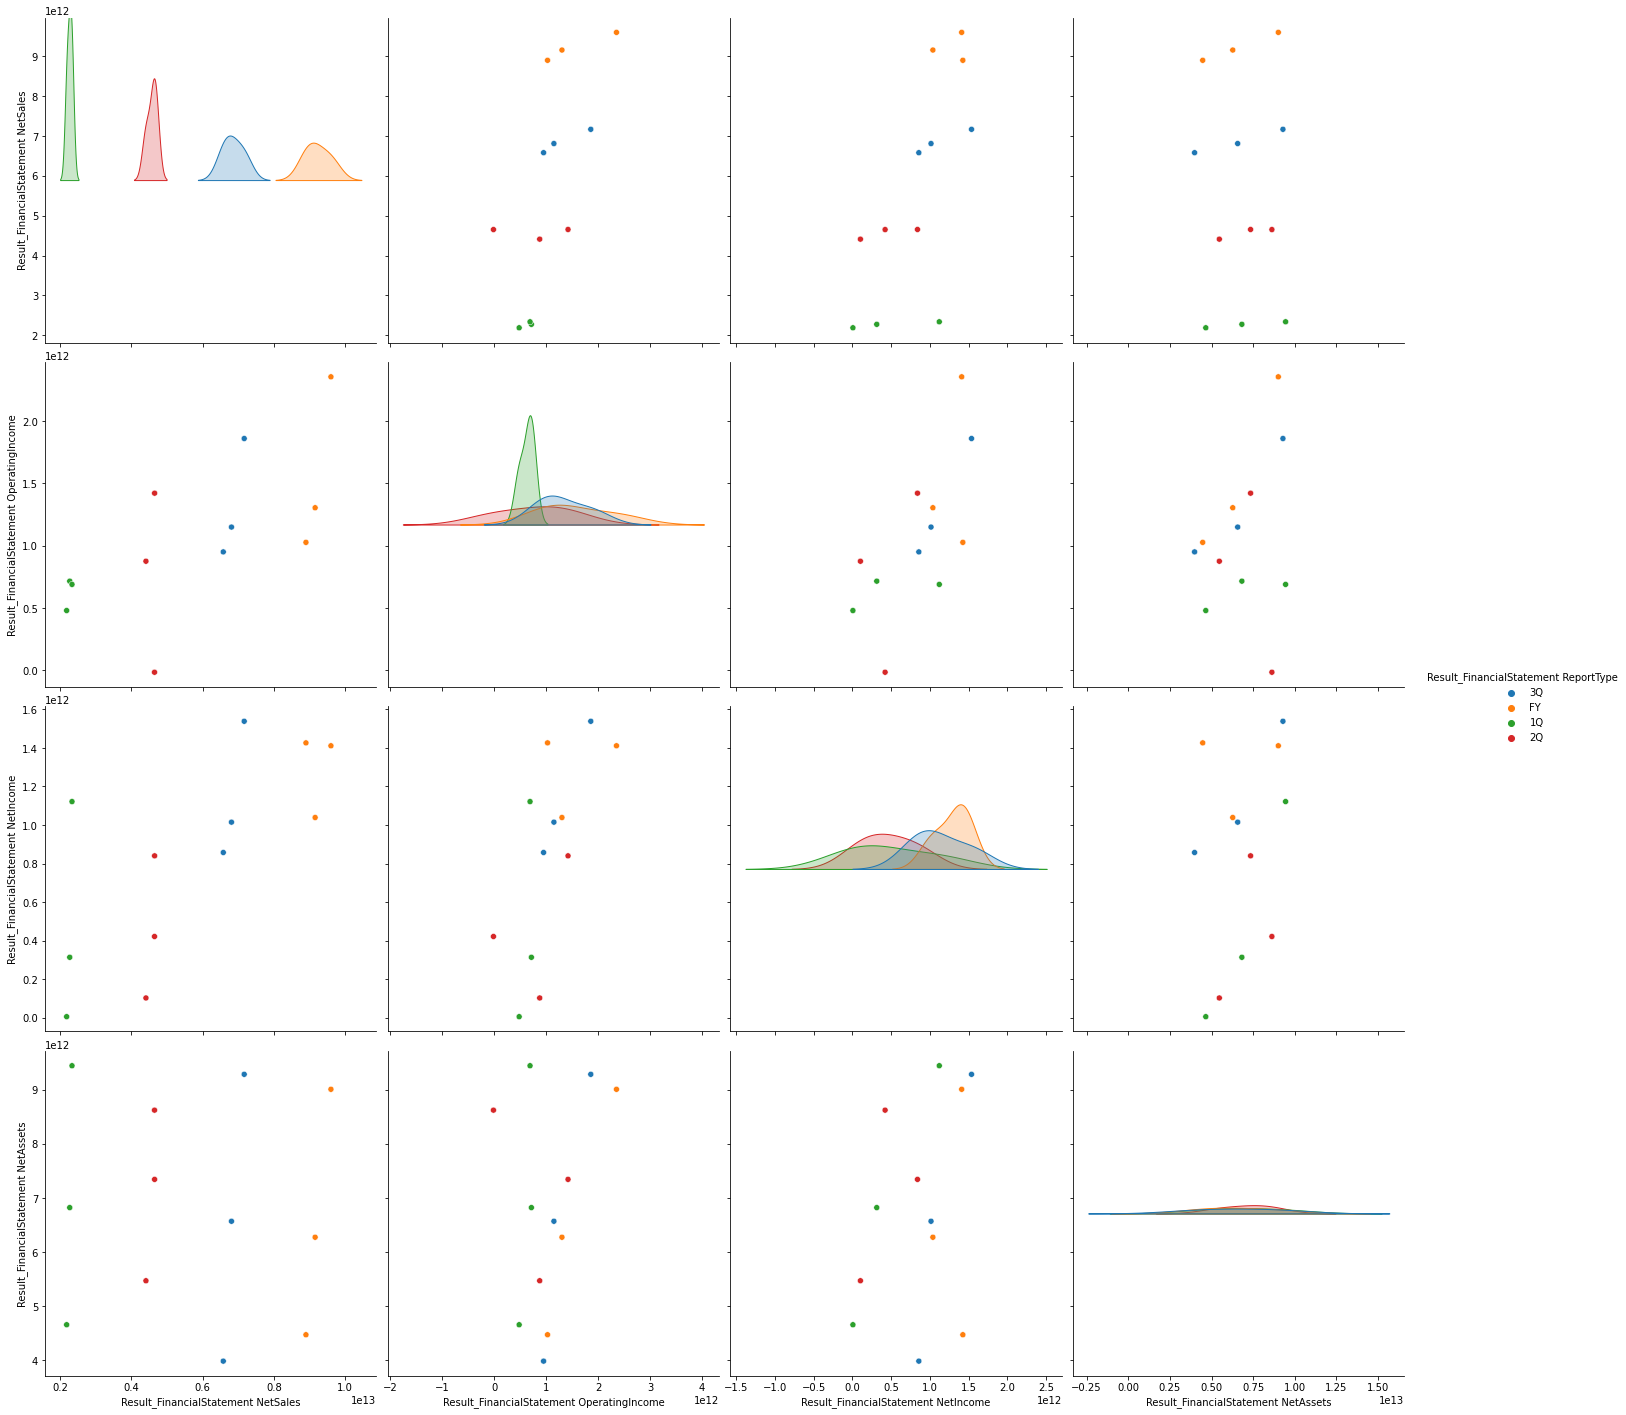

In [57]:
# stock_fin
# 銘柄コード9984にデータを絞る
code = 9984
fin_data = stock_fin[stock_fin["Local Code"] == code]

# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

#### Chapter 2.5.1 複数銘柄のファンダメンタル情報の比較

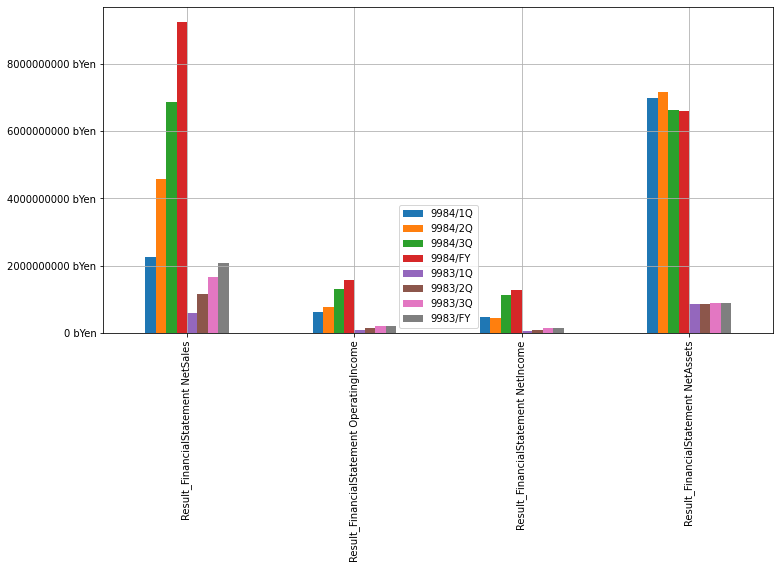

In [58]:
# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

#### Chapter 2.5.2 株価の終値の動き

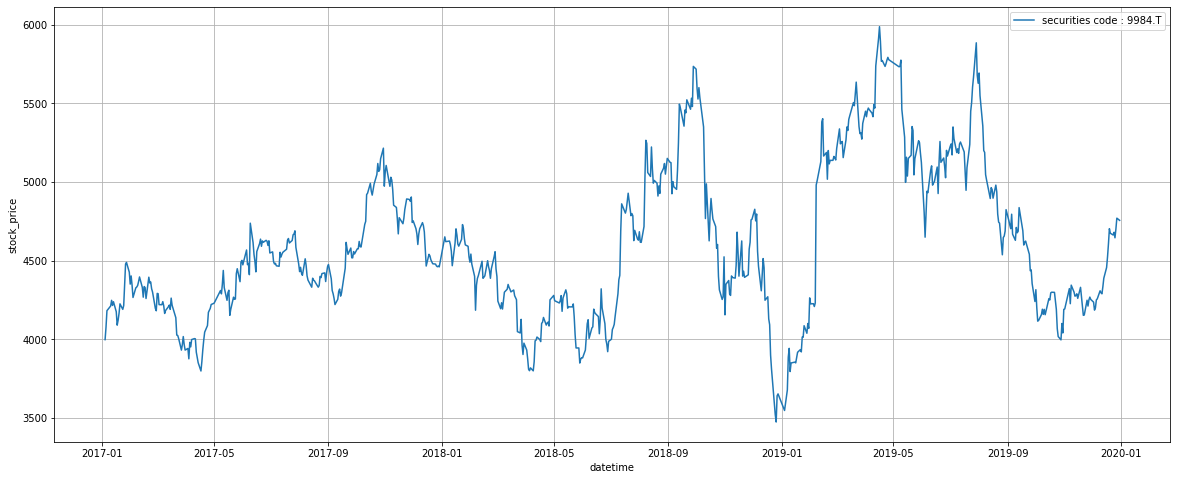

In [61]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

#### Chapter 2.5.3 移動平均

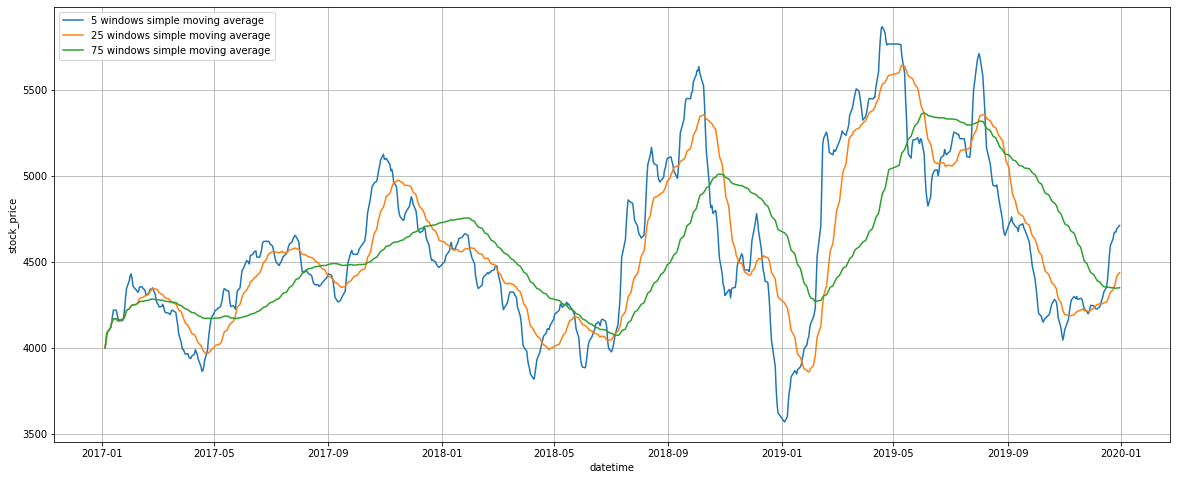

In [62]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig2, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

#### Chapter 2.5.4 価格変化率


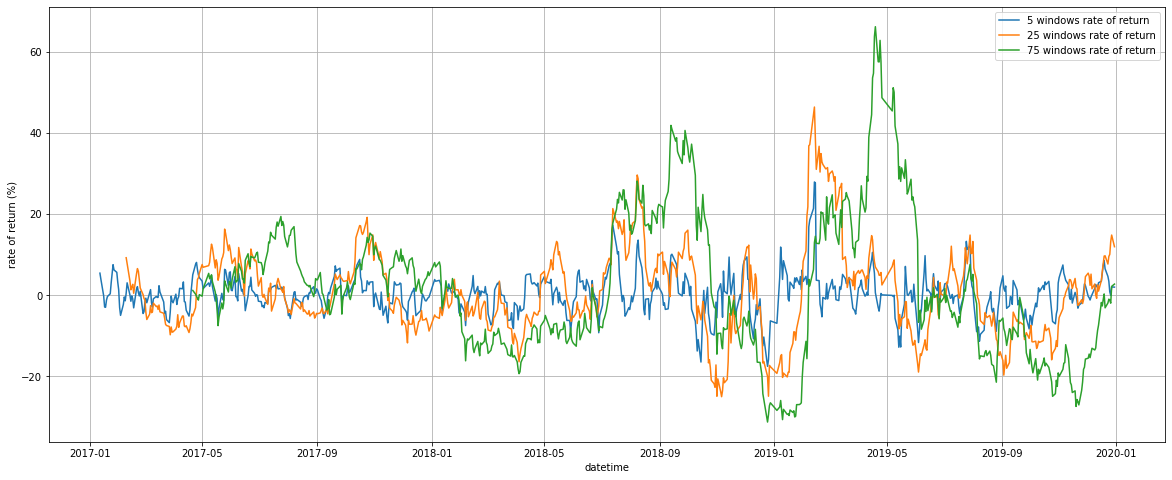

In [63]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

#### Chapter 2.5.5 ヒストリカル・ボラティリティ

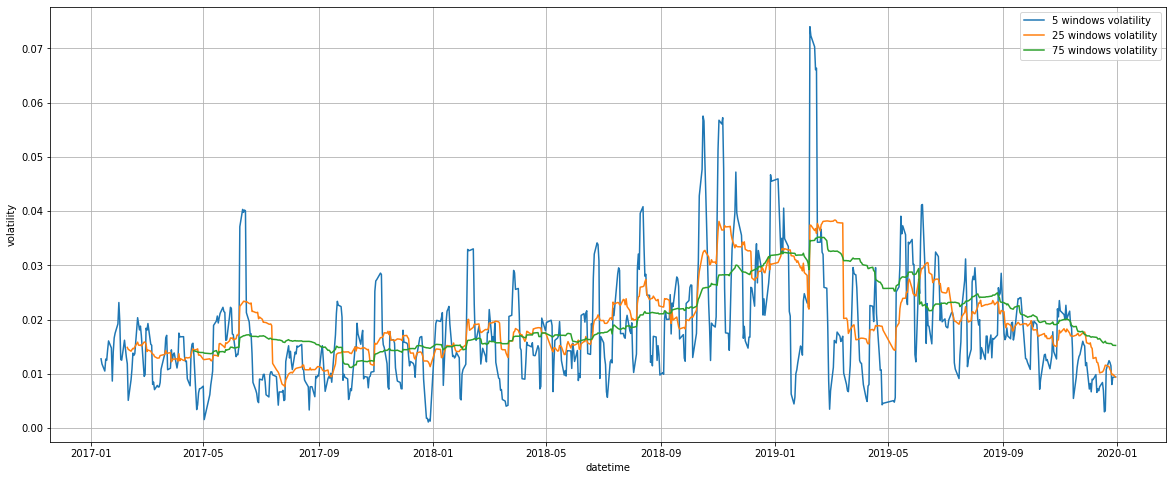

In [64]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

#### Chapter 2.5.6 複数のデータを同時にプロット

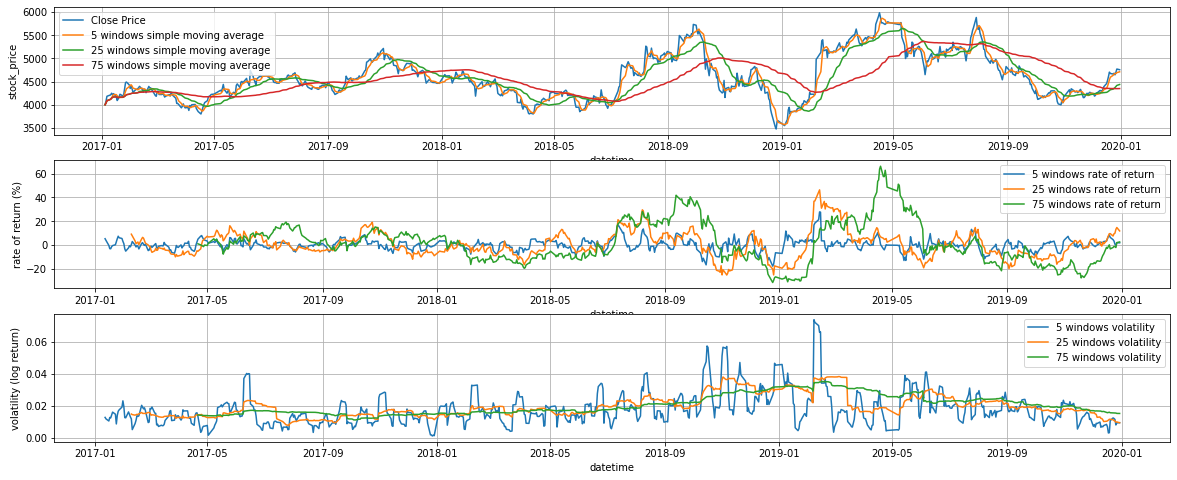

In [65]:
# 特定の銘柄コードに絞り込み
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

#### Chapter 2.6.2


In [ ]:
# うまく動かないので一旦スキップ。元のチュートリアルで使われたdataframeはindexが日付かつ全営業日

# memo: stock_finの内容を変更してしまうとセルの実行に途中で失敗してしまったとき厄介なのでなるべく変更しない

# 2019年までの値を表示
# fin_data = stock_fin[stock_fin["base_date"] < "2019-12-31"]

# # データ数の確認
# print(fin_data.shape)

# # データの欠損値数を確認
# print(fin_data.isna().sum())

# 欠損値の数を年別に集計
#fin_data = fin_data.isna()
#fin_data["year"] = fin_data["base_date"].year
#stock_fin
# # データの欠損値をプロット
# fig, ax = plt.subplots(figsize=(20, 5))
# sns.heatmap(fin_data.groupby("year").agg("sum"), ax=ax)

In [66]:
# 銘柄コード9984にデータを絞る
code = 9984
fin_data = stock_fin[stock_fin["Local Code"] == code]

# float64型の列に絞り込み
fin_data = fin_data.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

In [67]:
fin_data.head(1).T

base_date,2017-02-08
Result_FinancialStatement TotalAssets,2.486704e+13
Result_FinancialStatement NetAssets,3.981711e+12
Result_FinancialStatement NetSales,6.581466e+12
Result_FinancialStatement OperatingIncome,9.496600e+11
Result_FinancialStatement OrdinaryIncome,9.752570e+11
Result_FinancialStatement NetIncome,8.574310e+11
Forecast_FinancialStatement NetSales,0.000000e+00
Forecast_FinancialStatement OperatingIncome,0.000000e+00
Forecast_FinancialStatement NetIncome,0.000000e+00
Forecast_FinancialStatement OrdinaryIncome,0.000000e+00


### Define features

1/2/3monthのリターンに加えて標準偏差、移動平均乖離率などの特徴量生成

※時刻は分析対象データを決算後翌営業日から一週間で価格データが存在していた銘柄のみにフィルタリング

#### Chapter 2.7.3


In [68]:
# 銘柄コード9984にデータを絞る
code = 9984
price_data = stock_price[stock_price["Local Code"] == code]

# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

In [69]:
feats.tail(1).T

base_date,2022-08-31
return_1month,0.020550
return_2month,0.052811
return_3month,0.031720
volatility_1month,0.027973
volatility_2month,0.022922
volatility_3month,0.024438
MA_gap_1month,0.987238
MA_gap_2month,1.003003
MA_gap_3month,1.023082


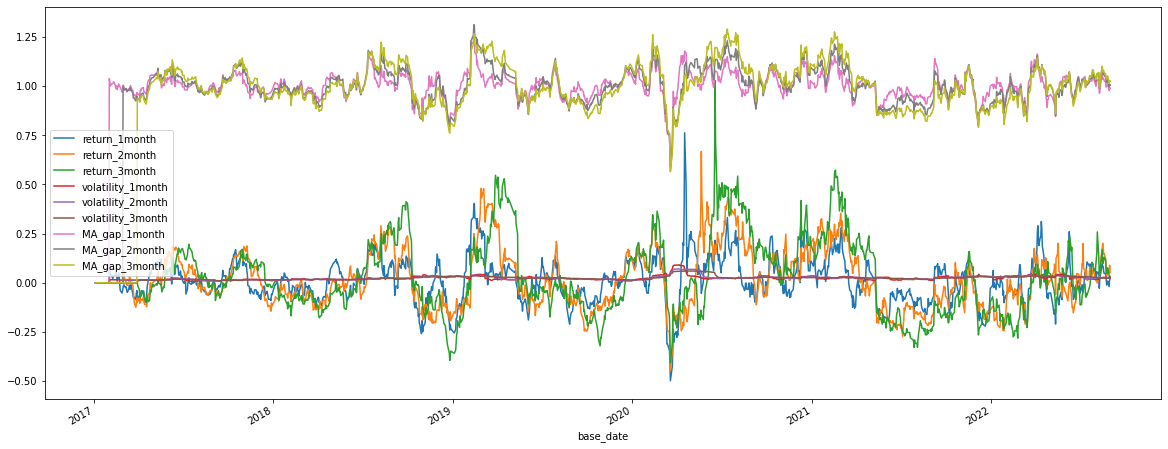

In [70]:
feats.plot(figsize=(20,8))

### バックテスト期間の設定
#### Chapter 2.8.2


In [71]:
# データ分割期間を定義
TRAIN_END = "2020-12-31"
VAL_START = "2021-02-01"
VAL_END = "2021-12-01"
TEST_START = "2022-01-01"

### 特徴量の生成
#### Chapter 2.9.1


In [75]:
def get_features_for_predict(stock_fin, stock_price, code:int, start_dt="2017-01-01"):
    """
    Args:
        stock_fin (dict)  : pd.DataFrame that includes financial statements data
        stock_price (dict) : pd.DataFrame that includes stock price data
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目

    # 特定の銘柄コードのデータに絞る
    price_data = stock_price[stock_price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [76]:
df = get_features_for_predict(stock_fin, stock_price, 9984)
df.T

base_date,2017-02-08,2017-05-10,2017-08-07,2017-11-06,2018-02-07,2018-05-09,2018-08-06,2018-11-05,2019-02-06,2019-05-09,...,2020-05-18,2020-08-11,2020-11-09,2021-02-08,2021-05-12,2021-08-10,2021-11-08,2022-02-08,2022-05-12,2022-08-08
return_1month,2.224838e-02,8.804402e-02,9.961943e-03,8.356941e-02,-5.596001e-02,1.203510e-01,1.374653e-01,-2.102032e-01,8.878024e-02,5.914718e-02,...,4.547511e-02,1.112701e-02,1.229098e-02,1.874061e-01,-8.200000e-02,-7.439024e-02,7.028441e-03,-1.082090e-02,-2.097484e-01,5.462963e-02
return_2month,0.000000e+00,4.466859e-02,-4.780498e-02,1.592260e-01,-6.940874e-02,7.893497e-03,1.775059e-01,-1.119797e-01,-1.097317e-01,1.015737e-01,...,2.591281e-01,2.268081e-01,2.476660e-01,2.665242e-01,-1.078717e-01,-1.484667e-01,-1.519615e-01,-4.485678e-02,-6.046025e-02,2.705140e-02
return_3month,0.000000e+00,-3.892833e-03,4.227793e-02,1.126650e-01,-1.333666e-01,-1.530847e-02,1.065103e-01,-1.693257e-01,-3.258260e-02,3.665405e-01,...,-1.624071e-01,4.041943e-01,1.438953e-01,4.056017e-01,-6.402936e-02,-1.932207e-01,-8.195500e-02,-1.910284e-01,-1.529611e-01,1.299603e-01
volatility_1month,1.522609e-02,1.157811e-02,1.171816e-02,1.838358e-02,1.995841e-02,1.387375e-02,2.234456e-02,4.054193e-02,1.672133e-02,1.514235e-02,...,2.807880e-02,2.506267e-02,2.384297e-02,2.275651e-02,2.065968e-02,1.977324e-02,2.387446e-02,3.373814e-02,3.143513e-02,1.761088e-02
volatility_2month,0.000000e+00,1.290494e-02,1.194563e-02,1.601125e-02,1.687287e-02,1.634615e-02,2.083745e-02,3.290983e-02,2.824798e-02,1.593598e-02,...,6.368045e-02,2.546068e-02,2.594448e-02,2.789580e-02,2.169633e-02,1.860736e-02,2.472139e-02,2.611408e-02,3.410747e-02,2.253288e-02
volatility_3month,0.000000e+00,1.331634e-02,1.679778e-02,1.444113e-02,1.580369e-02,1.608024e-02,1.943844e-02,2.879765e-02,2.756937e-02,2.729567e-02,...,5.734101e-02,2.369026e-02,2.668409e-02,2.525342e-02,2.468207e-02,1.757115e-02,2.554451e-02,2.922613e-02,3.453708e-02,2.067304e-02
MA_gap_1month,1.012936e+00,1.066627e+00,9.912226e-01,9.996080e-01,9.540805e-01,1.044586e+00,1.007283e+00,9.445341e-01,1.052259e+00,1.014114e+00,...,1.010287e+00,9.711673e-01,1.015520e+00,1.099086e+00,9.226965e-01,9.563142e-01,9.728023e-01,1.004005e+00,8.455000e-01,1.034411e+00
MA_gap_2month,0.000000e+00,1.070177e+00,9.902299e-01,1.054210e+00,9.530104e-01,1.043655e+00,1.074974e+00,8.712824e-01,1.046151e+00,1.043537e+00,...,1.100513e+00,1.052475e+00,1.051756e+00,1.135687e+00,9.293332e-01,9.166390e-01,9.567253e-01,9.896869e-01,8.490606e-01,1.065482e+00
MA_gap_3month,0.000000e+00,1.051330e+00,1.002253e+00,1.079846e+00,9.376535e-01,1.019751e+00,1.101696e+00,8.690109e-01,1.006648e+00,1.073046e+00,...,1.043319e+00,1.123141e+00,1.073711e+00,1.201469e+00,9.194558e-01,8.838847e-01,9.599040e-01,9.348579e-01,8.603091e-01,1.068230e+00
Result_FinancialStatement TotalAssets,2.486704e+13,2.463421e+13,2.488313e+13,2.797348e+13,2.941272e+13,3.118047e+13,3.226836e+13,3.380756e+13,3.645948e+13,3.609648e+13,...,3.725729e+13,3.356335e+13,3.564820e+13,3.785879e+13,4.575045e+13,4.718560e+13,4.622079e+13,4.824289e+13,4.754467e+13,4.697634e+13


### 目的変数の生成
#### Chapter 2.9.2


In [77]:
def get_features_and_label(stock_labels, codes, feature, label):
    """
    Args:
        stock_labels (pd.DataFame): label data for training
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # 特定の銘柄コードのデータに絞る
        labels = stock_labels[stock_labels["Local Code"] == code].copy()

        # 特定の目的変数に絞る
        labels = labels[label].copy()
        # nanを削除
        labels.dropna(inplace=True)
        #print(labels)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [78]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(stock_fin, stock_price, codes[0])
# 特徴量と目的変数を一致させて、データを分割
ret = get_features_and_label(stock_labels, codes, feat, label)
for v in ret:
    print(v.T)

  0%|          | 0/1 [00:00<?, ?it/s]

base_date                                      2017-02-08    2017-05-10  \
return_1month                                2.224838e-02  8.804402e-02   
return_2month                                0.000000e+00  4.466859e-02   
return_3month                                0.000000e+00 -3.892833e-03   
volatility_1month                            1.522609e-02  1.157811e-02   
volatility_2month                            0.000000e+00  1.290494e-02   
volatility_3month                            0.000000e+00  1.331634e-02   
MA_gap_1month                                1.012936e+00  1.066627e+00   
MA_gap_2month                                0.000000e+00  1.070177e+00   
MA_gap_3month                                0.000000e+00  1.051330e+00   
Result_FinancialStatement TotalAssets        2.486704e+13  2.463421e+13   
Result_FinancialStatement NetAssets          3.981711e+12  4.469730e+12   
Result_FinancialStatement NetSales           6.581466e+12  8.901004e+12   
Result_FinancialStatement

In [79]:
def get_codes(stock_list):
    """
    Args:
        stock_list (pd.DataFrame): stock list
    Returns:
        array: list of stock codes
    """
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [80]:
# 対象の目的変数を定義
if 'google.colab' in sys.modules:
    labels = {
        "label_high_20",
        "label_low_20",
    }
else:
    labels = {
        "label_high_5",
        "label_high_10",
        "label_high_20",
        "label_low_5",
        "label_low_10",
        "label_low_20",
    }
print(labels)

# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(stock_list)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(stock_fin, stock_price, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(stock_labels, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

{'label_low_20', 'label_high_20'}


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Create Model
#### Chapter 2.9.3


In [81]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

RandomForestRegressor(random_state=0)

### Predict
#### Chapter 2.10.1

In [82]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 特徴量グループを定義　
# ファンダメンタル
fundamental_cols = stock_fin.select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 特徴量グループを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

X has feature names, but RandomForestRegressor was fitted without feature names


### 重要度
#### Chapter 2.11.1


Text(0.5, 0, 'Random Forest Feature Importance')

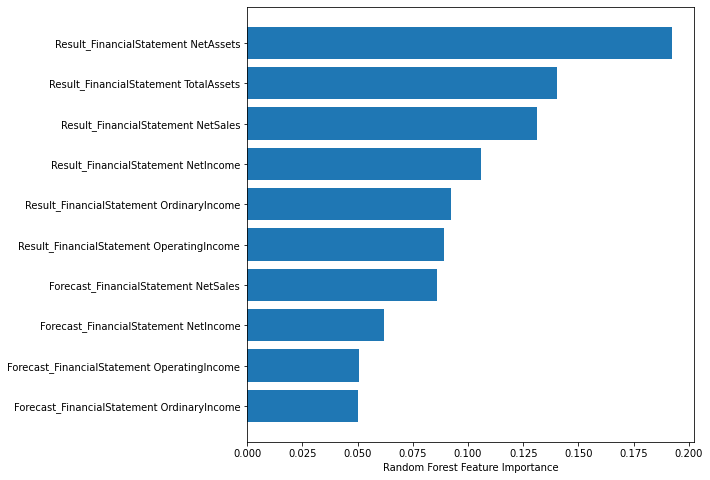

In [83]:
rf = pred_model

# プロット
fig, ax = plt.subplots(figsize=(8, 8))
sorted_idx = rf.feature_importances_.argsort()
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

### SHAP分析
#### Chapter 2.11.2


In [84]:
# xgboostモデル学習　
train_X_code_int = train_X["label_high_20"].copy()
train_X_code_int["code"] = train_X_code_int["code"].astype(int)
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X_code_int, label=train_y["label_high_20"]), 100)

model_output = "margin" has been renamed to model_output = "raw"


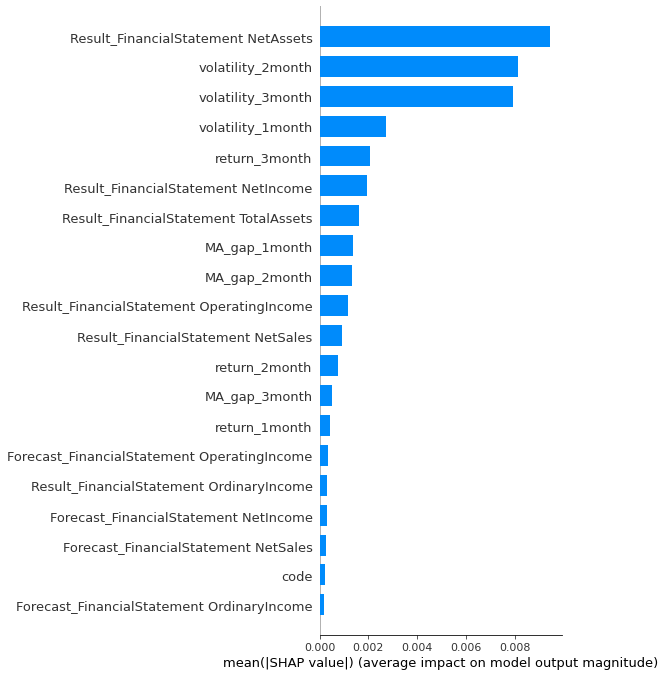

In [85]:
shap.initjs()

explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')

shap_values = explainer.shap_values(X=train_X_code_int)

shap.summary_plot(shap_values, train_X_code_int, plot_type="bar")

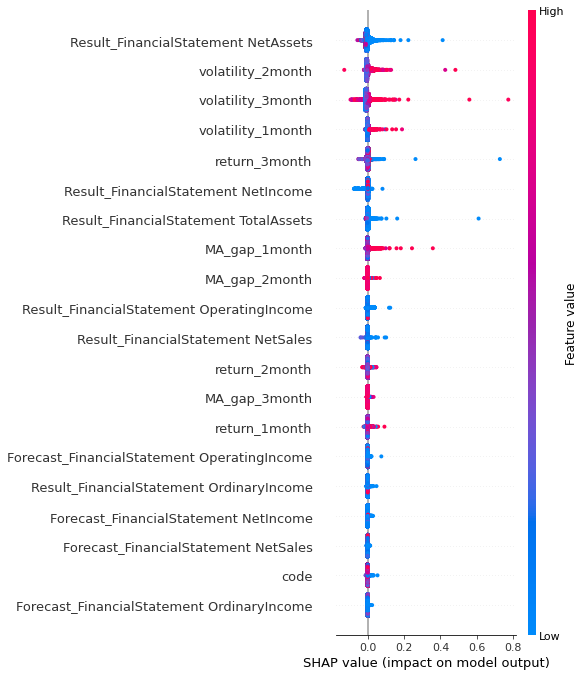

In [86]:
shap.summary_plot(shap_values, train_X_code_int)

### Check all the patterns
#### Chapter 2.12.1


In [1]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 学習済みモデル保存用
trained_models = dict()
# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    trained_models[model] = dict()
    # データセット毎に処理
    for col in tqdm(columns.keys()):
        result = dict()
        trained_models[model][col] = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 学習済みモデル保存
                trained_models[model][col][label] = pred_model
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

NameError: ignored

In [ ]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results["id"] = results["code"].astype(str)+results["datetime"].dt.strftime('%Y%m%d')
results.head(5)

code   datetime   predict  predict_dir    actual  \
             base_date                                                      
label_low_20 2022-02-04  1301 2022-02-04 -0.065088         -1.0 -0.035385   
             2022-05-13  1301 2022-05-13 -0.073460         -1.0 -0.021538   
             2022-02-04  1332 2022-02-04 -0.063331         -1.0 -0.068266   
             2022-05-12  1332 2022-05-12 -0.055956         -1.0 -0.020755   
             2022-02-07  1333 2022-02-07 -0.059798         -1.0 -0.067627   

                         actual_dir model           feature         label  \
             base_date                                                      
label_low_20 2022-02-04        -1.0    rf  fundamental_only  label_low_20   
             2022-05-13        -1.0    rf  fundamental_only  label_low_20   
             2022-02-04        -1.0    rf  fundamental_only  label_low_20   
             2022-05-12        -1.0    rf  fundamental_only  label_low_20   
             2022-02-07        -1.0    rf  fundamental_only  label_low_20   

                                   id  
             base_date                 
label_low_20 2022-02-04  130120220204  
             2022-05-13  130120220513  
             2022-02-04  133220220204  
             2022-05-12  133220220512  
             2022-02-07  133320220207

#### Chapter2.12.2


In [ ]:
all_metrics = []

for feature in columns:
    matrix = dict()
    for model in models:
        for label in labels:
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

,index,RMSE,accuracy,spearman_corr,corr,R^2 score,feature,model,# of samples
0,label_low_20,0.092023,0.843433,0.178007,0.212764,0.045269,fundamental_only,rf,4637
1,label_high_20,0.176162,0.839336,0.187111,0.257153,0.066128,fundamental_only,rf,4637
2,label_low_20,0.092441,0.843002,0.189517,0.216176,0.046732,fundamental_only,extraTree,4637
3,label_high_20,0.17901,0.839336,0.191104,0.214232,0.045895,fundamental_only,extraTree,4637
4,label_low_20,0.090513,0.843433,0.190305,0.234082,0.054794,fundamental_only,gbr,4637
5,label_high_20,0.174861,0.839551,0.170794,0.24607,0.06055,fundamental_only,gbr,4637
6,label_low_20,0.096875,0.842571,0.082715,0.100947,0.01019,return_only,rf,4637
7,label_high_20,0.182716,0.838042,0.182991,0.175572,0.030826,return_only,rf,4637
8,label_low_20,0.098376,0.839767,0.075353,0.091258,0.008328,return_only,extraTree,4637
9,label_high_20,0.184667,0.836532,0.170658,0.161724,0.026155,return_only,extraTree,4637


In [ ]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
agg = all_metrics.reset_index().groupby(["index","feature"]).agg("mean")
agg

RMSE  accuracy  spearman_corr  \
index         feature                                                    
label_high_20 fundamental+technical  0.174370  0.839551       0.261411   
              fundamental_only       0.176678  0.839408       0.183003   
              return_only            0.182230  0.838042       0.182919   
              technical_only         0.176800  0.839480       0.266267   
label_low_20  fundamental+technical  0.091789  0.843433       0.196392   
              fundamental_only       0.091659  0.843289       0.185943   
              return_only            0.095686  0.841852       0.104920   
              technical_only         0.093311  0.843361       0.169762   

                                         corr  R^2 score  
index         feature                                     
label_high_20 fundamental+technical  0.288710   0.083640  
              fundamental_only       0.239152   0.057524  
              return_only            0.173655   0.030238  
              technical_only         0.249813   0.062589  
label_low_20  fundamental+technical  0.225603   0.052029  
              fundamental_only       0.221007   0.048932  
              return_only            0.122056   0.016261  
              technical_only         0.189314   0.037648

### Submit Model

In [ ]:
# モデル保存用にメソッドを定義します
def save_model(model, label, model_path="../model"):
    # モデル保存先ディレクトリを作成
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        # モデルをpickle形式で保存
        pickle.dump(model, f)

In [ ]:
# 保存した学習済みモデルから、提出するモデルを選択してpickle形式で保存します。
# 使用するモデルや特徴量を変更する際は、学習時と推論時で同一の特徴量をモデルに
# 入力するために提出用のpredictor.pyについても変更する必要があることにご注意ください。

# モデルの保存先を指定します。
model_path = f"{STORAGE_DIR_PATH}/model"
# モデルの種類
models = ["rf"]
# 使用する特徴量カラム
columns = ["fundamental+technical"]
# 目的変数
labels = [
    "label_high_20",
    "label_low_20",
]

# モデル毎に処理
for model in models:
    # 特徴量毎に処理
    for col in columns:
        # 目的変数毎に処理
        for label in labels:
            # 学習済みモデルを取得
            pred_model = trained_models[model][col][label]
            # モデルを保存
            save_model(pred_model, label, model_path=model_path)

これでこちらのチュートリアル、ならびにこのノートブックは終了になります。
お疲れ様でした！